# Results Optiwise rudder as input

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from vessel_manoeuvring_models.models.rudder_simple import RudderSimpleSystem
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert
from matplotlib.patches import Ellipse
from phd.visualization.units import units

In [3]:
ship_name = "optiwise"

In [4]:
loaders = {
    #"polynomial rudder" : catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple'],
    "semiempirical rudder" : catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia'],
}

[11/11/24 10:12:30] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=538078;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=826022;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=435962;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=128927;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_VCT_MDL'                        ]8;id=504080;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=707809;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [5]:
models = {name:loader() for name,loader in loaders.items()}

In [6]:
model = models["semiempirical rudder"].copy()
model.subsystems.pop('mmg_wake_system')
rudder = RudderSimpleSystem(ship=model)
model.subsystems['rudder'] = rudder
model.control_keys=['X_RM','Y_RM','thrust']
models['rudder forces'] = model

In [7]:
styles={'Experiment':{'style':'k-','label':'Experiment'}}
styles.update({key:{'label':key,'style':'--',} for key in models.keys()})

In [8]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")
id_exists = [int(key) for key in catalog.load(f"{ship_name}.tests_ek_smooth1").keys()]
#id_exists = [int(key) for key in catalog.load(f"{ship_name}.tests_ek1").keys()]

ids = sorted(list(set(id_exists) & set(meta_data_all.index)))

meta_data_all = meta_data_all.loc[ids].copy()
#ids = [int(key) for key in catalog.load("wPCC.tests_ek_smooth1").keys()]

mask = ((meta_data_all['test_type'] == 'zigzag') & (meta_data_all['ship_speed'] > 0.9))

meta_datas = meta_data_all.loc[mask].copy()

ids = [
    23590,
    23591,
    23594,
    23596,
]
meta_datas = meta_datas.loc[ids].copy()
meta_datas['angle'] = [
    -10,
    10,
    -20,
    20,
]

[11/11/24 10:13:03] INFO     Loading data from 'optiwise.time_series_meta_data' (CSVDataSet)... ]8;id=98894;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=170461;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=861879;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=166846;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=732708;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=109699;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=449966;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=37498;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=64967;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=771350;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=602318;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=791334;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/11/24 10:13:04] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=134452;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=689025;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=597703;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=837135;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/11/24 10:13:05] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=695913;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=992973;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=806505;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=420404;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/11/24 10:13:06] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=728992;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=958685;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=592133;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=888973;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

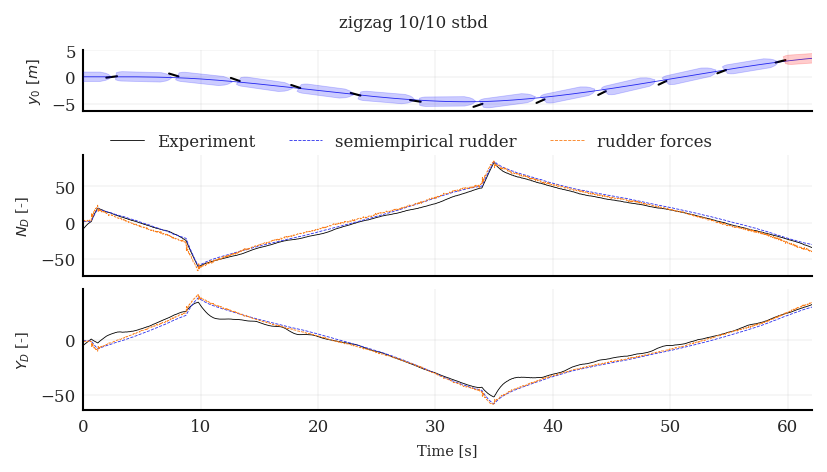

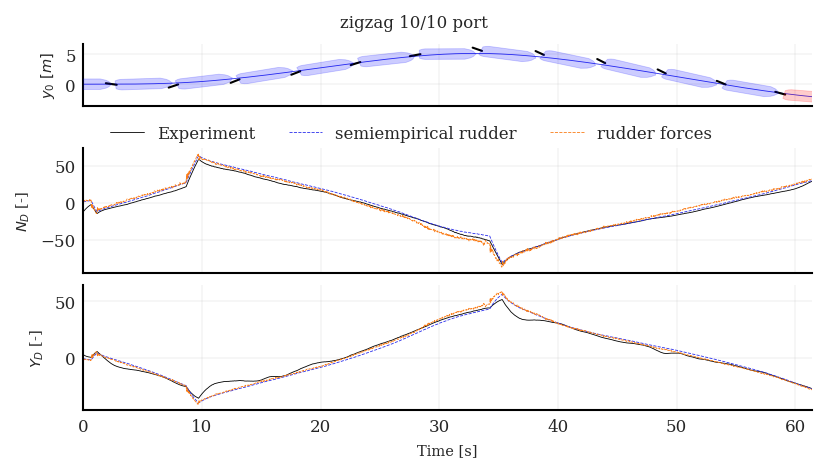

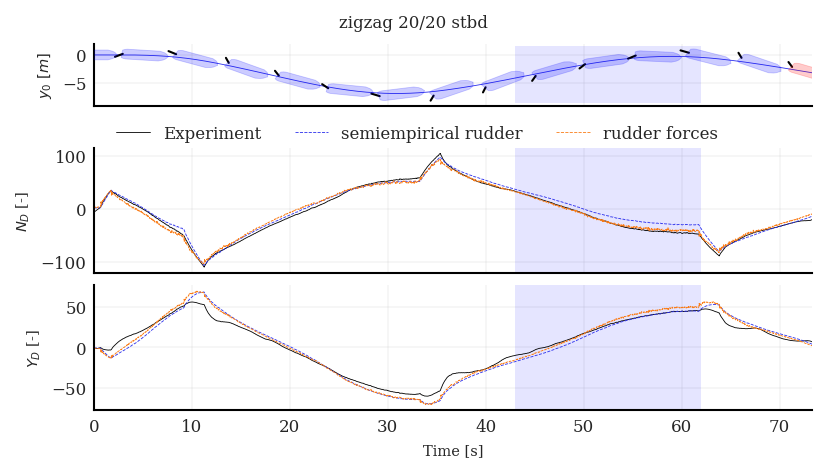

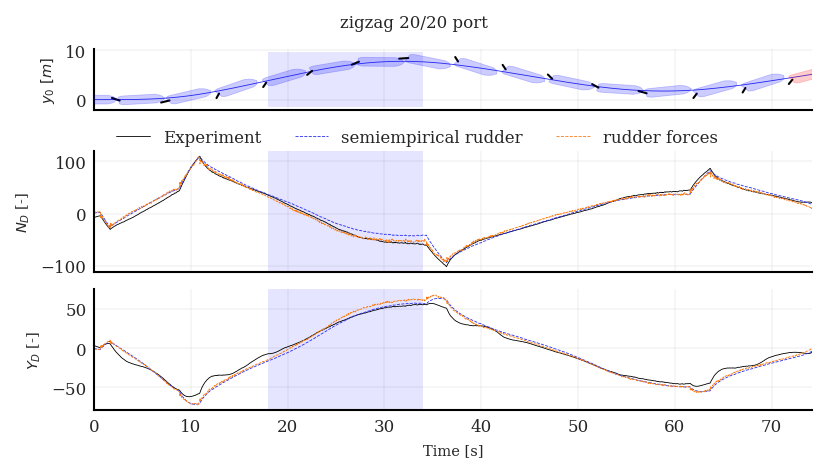

In [9]:
for i,(id, meta_data) in enumerate(meta_datas.iterrows()):

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
    data_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    df_EKF_smooth = pd.merge(left=df_EKF_smooth, right=data_raw, how='left', left_index=True, right_index=True, suffixes=('','_raw'))

    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']
    
    #df_EKF_smooth['N_R'] = df_EKF_smooth['Y_R'] * ship_data['x_r']
    
    #df_EKF_smooth = catalog.load("wPCC.tests_ek1")[str(id)]()
    #df_EKF_smooth['thrust'] = df_EKF_smooth['thrust_port'] + df_EKF_smooth['thrust_stbd']
    #data = load(id=id, catalog=catalog, smooth=False)
    #data = filter(data,cutoff=1)
    #data = data.iloc[100:-100].copy()

    if id==22774:
        #data=data.loc[0:70].copy()
        df_EKF_smooth = df_EKF_smooth.loc[0:70].copy()


    #fig = plot_compare_model_forces(model=models['polynomial rudder (SINDy)'], models=models, data=df_EKF_smooth, styles=styles, keys=['N_D','Y_D','N_H','N_R','N_RHI',], delta_corners=False);
    fig = plot_compare_model_forces(model=models['rudder forces'], models=models, data=df_EKF_smooth, styles=styles, keys=['N_D','Y_D'], delta_corners=False);
    
    
    #fig.axes[-1].legend(loc='upper center', bbox_to_anchor=(0.05, 1.7), ncol=1)
    #fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.25, 1.7), ncol=3)
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.30), ncol=3)
    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    fig.suptitle(name)


    if i==2:
        for ax in fig.axes:
            ylims = ax.get_ylim()
            ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1)
    
    if i==3:
        for ax in fig.axes:
            ylims = ax.get_ylim()
            ax.fill([18,18,34,34], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1)
    
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")



[11/11/24 10:17:27] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=930976;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=662678;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=455904;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=525456;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=739441;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=145835;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[11/11/24 10:17:28] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=262038;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=296081;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

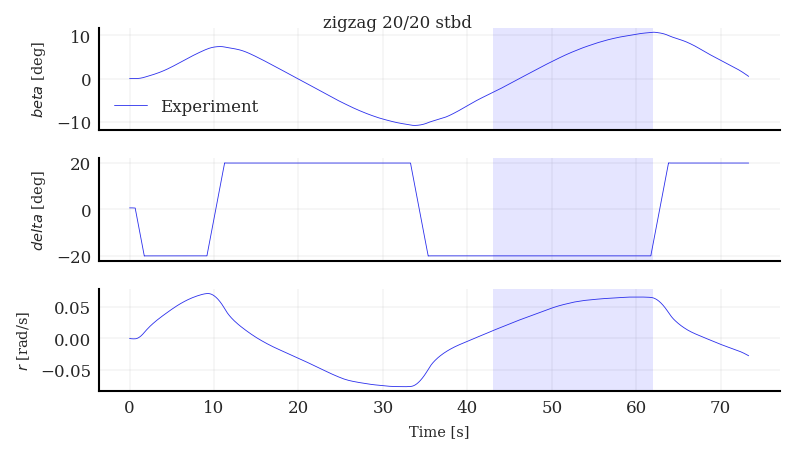

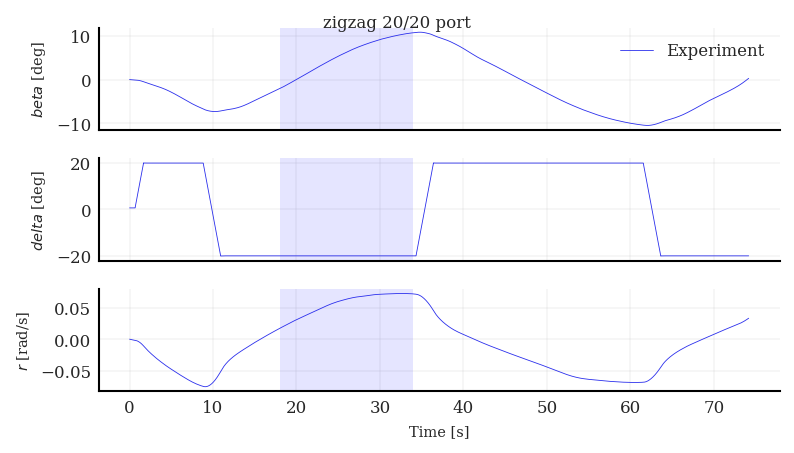

In [10]:

for i,(id, meta_data) in enumerate(meta_datas.iloc[2:].iterrows()):

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    fig = plot(dataframes={'Experiment':df_EKF_smooth}, keys=['delta','beta','r'], ncols=1, units=units);

    if i==0:
        for ax in fig.axes:
            ylims = ax.get_ylim()
            ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1)
    
    if i==1:
        for ax in fig.axes:
            ylims = ax.get_ylim()
            ax.fill([18,18,34,34], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1)

    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    fig.suptitle(name)

    file_name = name.replace("/","_")
    paper.save_fig(fig, f"states {file_name}.svg")

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=484909;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=225431;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=16008;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=808096;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/11/24 10:17:29] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=797680;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=958779;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=754746;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=320197;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/11/24 10:17:30] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=332294;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=982739;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=768378;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=285067;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=45133;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=746615;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=433037;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=523501;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

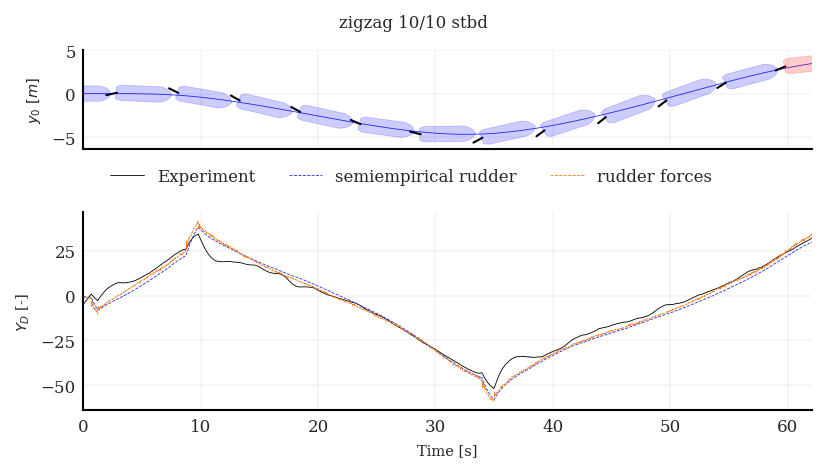

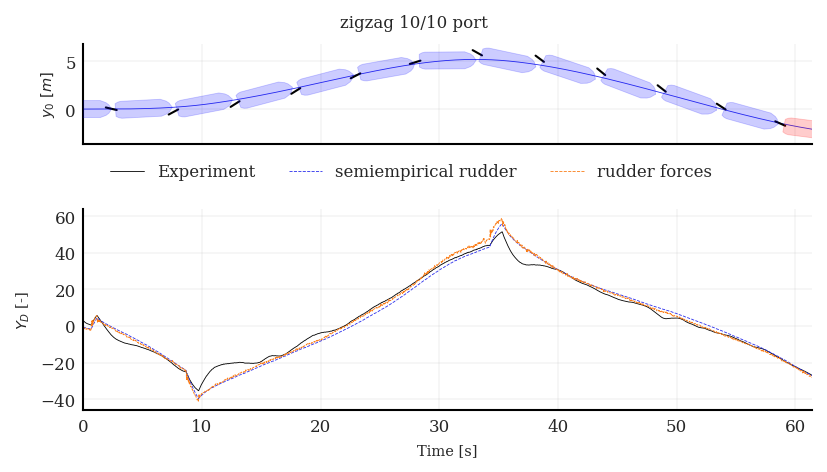

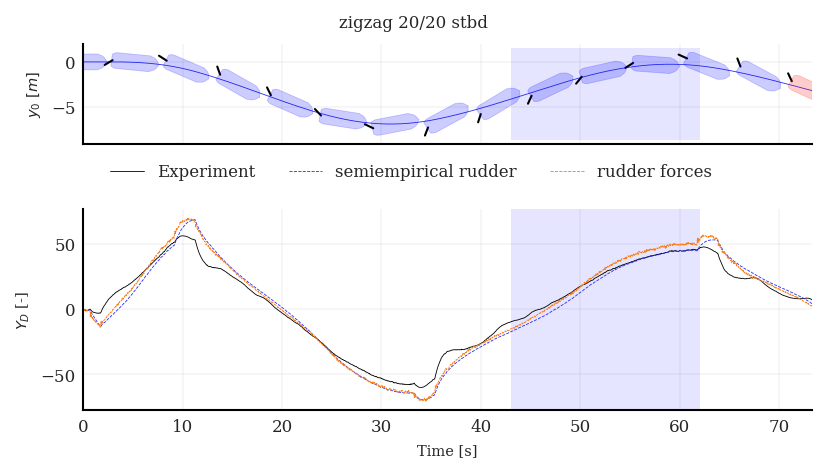

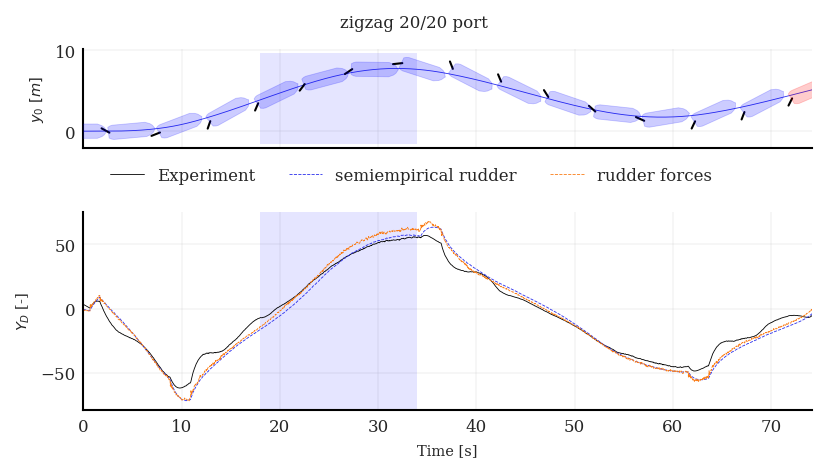

In [11]:
for i,(id, meta_data) in enumerate(meta_datas.iterrows()):

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
    data_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    df_EKF_smooth = pd.merge(left=df_EKF_smooth, right=data_raw, how='left', left_index=True, right_index=True, suffixes=('','_raw'))

    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']
    
    #df_EKF_smooth['N_R'] = df_EKF_smooth['Y_R'] * ship_data['x_r']
    
    #df_EKF_smooth = catalog.load("wPCC.tests_ek1")[str(id)]()
    #df_EKF_smooth['thrust'] = df_EKF_smooth['thrust_port'] + df_EKF_smooth['thrust_stbd']
    #data = load(id=id, catalog=catalog, smooth=False)
    #data = filter(data,cutoff=1)
    #data = data.iloc[100:-100].copy()

    if id==22774:
        #data=data.loc[0:70].copy()
        df_EKF_smooth = df_EKF_smooth.loc[0:70].copy()


    #fig = plot_compare_model_forces(model=models['polynomial rudder (SINDy)'], models=models, data=df_EKF_smooth, styles=styles, keys=['N_D','Y_D','N_H','N_R','N_RHI',], delta_corners=False);
    fig = plot_compare_model_forces(model=models['rudder forces'], models=models, data=df_EKF_smooth, styles=styles, keys=['Y_D'], delta_corners=False);
    
    
    #fig.axes[-1].legend(loc='upper center', bbox_to_anchor=(0.05, 1.7), ncol=1)
    #fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.25, 1.7), ncol=3)
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.30), ncol=3)
    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    fig.suptitle(name)


    if i==2:
        for ax in fig.axes:
            ylims = ax.get_ylim()
            ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1)
    
    if i==3:
        for ax in fig.axes:
            ylims = ax.get_ylim()
            ax.fill([18,18,34,34], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1)
    
    file_name = name.replace("/","_")
    #paper.save_fig(fig, f"{file_name}.svg")